In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torcheval.metrics.functional import r2_score

In [3]:
from src.models import FCN, FCN_with_last_activation, FCN_with_parallel_branch
from src.data_handler import DataHandler, DataHandlerForAllSimulations, RandomSamplingDataHandler
from src.experiment_run import RunAllSimulations, Run
from src.constants import TIMESTEP_SCALE, GAMMA_SCALE, N_SCALE
from src.physics_loss import physics_loss_fixed_gamma_n, physics_loss_varied_gamma_n

In [4]:
def run_eval(x, y, run):
    print("R^2 score of the model: ", run.score().item())
    plt.plot(x, run.model(x).detach().numpy(), label="predicted ionization fraction")
    plt.plot(x, y, label="true ionization fraction")
    plt.xlabel("timestep")
    plt.ylabel("Ionized hydrogen fraction")
    plt.legend()

def all_run_eval(run):
    r2_scores, pred_best, y_best, pred_worst, y_worst = run.test()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    ax[0].plot(pred_best.detach().numpy(), label="Prediction")
    ax[0].plot(y_best.detach().numpy(), label="Target")
    ax[0].set_xlabel("Timestep")
    ax[0].set_ylabel("Ionized hydrogen fraction")
    ax[0].set_title(f"The most accurate approximation, R2={np.max(r2_scores)}")
    ax[0].legend()
    ax[1].plot(pred_worst.detach().numpy(), label="Prediction")
    ax[1].plot(y_worst.detach().numpy(), label="Target")
    ax[1].set_xlabel("Timestep")
    ax[1].set_ylabel("Ionized hydrogen fraction")
    ax[1].set_title(f"The least accurate approximation, R2={np.min(r2_scores)}")
    ax[1].legend()
    plt.show()
    return r2_scores

In [5]:
t_steps = 10000

# define the Universe time
u_time = np.arange(t_steps) # *dt.value

In [6]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [7]:
data = np.load('data/test1.npy').T
data.shape

(2000, 10000)

In [8]:
params = pd.read_csv('data/params1.txt', sep=' ')
params = params.values
params.shape

(2000, 2)

In [9]:
print("nH_max: ", np.max(params[:, 0]), "nH_min: ", np.min(params[:, 0]))
print("Gamma_max: ", np.max(params[:, 1]), "Gamma_min: ", np.min(params[:, 1]))

nH_max:  9.99922091498202e-08 nH_min:  1.0005353194024732e-09
Gamma_max:  9.950526533659972e-13 Gamma_min:  1.0010196311155132e-17


Key challenge of approximating the solution of ODE for all simulations by a single model is that target functions can look very different depending on Gamma and n. They can have different properties: linearity, convexity and max values can have different orders of magnitude

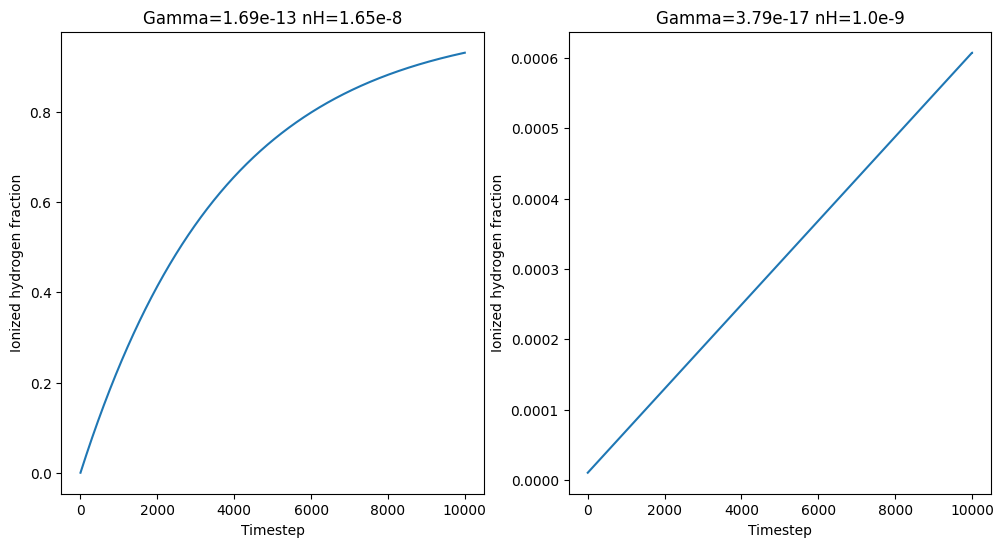

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax[0].plot(data[0])
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Ionized hydrogen fraction")
ax[0].set_title(f"Gamma={round(params[0, 1] * 1e13, 2)}e-13 nH={round(params[0, 0] * 1e8, 2)}e-8")
ax[1].plot(data[12])
ax[1].set_xlabel("Timestep")
ax[1].set_ylabel("Ionized hydrogen fraction")
ax[1].set_title(f"Gamma={round(params[12, 1] * 1e17, 2)}e-17 nH={round(params[12, 0] * 1e9, 2)}e-9")
plt.show()

In [11]:
timesteps = torch.tensor(u_time).float().view(-1,1)
y = torch.tensor(data).float()

In [12]:
print(y.shape)

torch.Size([2000, 10000])


We concatenate timesteps and physics parameters and apply rescaling for better convergence

Each feature tensor has format (timestep, n, gamma)

In [13]:
x = torch.zeros((2000, 10000, 3)) # n_simulations * n_timesteps * feature_dim
for i, row in enumerate(params):
    row = row * np.array([N_SCALE, GAMMA_SCALE])
    row_2d = np.broadcast_to(row, (10000, 2))
    row_2d = torch.tensor(row_2d).float()
    x[i] = torch.hstack((timesteps * TIMESTEP_SCALE, row_2d))
print(x[0, 0:5, :])

tensor([[0.0000e+00, 1.6522e-02, 1.6896e+00],
        [1.0000e-04, 1.6522e-02, 1.6896e+00],
        [2.0000e-04, 1.6522e-02, 1.6896e+00],
        [3.0000e-04, 1.6522e-02, 1.6896e+00],
        [4.0000e-04, 1.6522e-02, 1.6896e+00]])


# Case of one set of simulation hyperparameters

In [14]:
x_time = x[0, :, 0].view(-1, 1)
y_one_params = y[0].view(-1, 1)
gamma, nH = params[0].astype(float)

### Basic model

In [15]:
model = FCN_with_last_activation([1, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = Run('model_for_one_set_of_params_no_physics')

run.data_handler = DataHandler(x_time, y_one_params, 0, 2000, 20)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(1000)

torch.Size([100, 1]) torch.Size([9900, 1])


  0%|          | 2/1000 [00:00<00:54, 18.25it/s]

100%|██████████| 1000/1000 [00:33<00:00, 29.98it/s]


R^2 score of the model:  0.9809985160827637


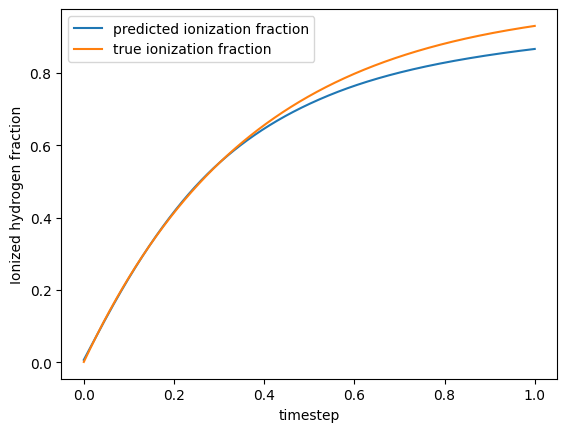

In [16]:
run_eval(x_time, y_one_params, run)

### PINN

In [17]:
model = FCN_with_last_activation([1, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = Run('model_for_one_set_of_params_physics_loss')

run.data_handler = DataHandler(x_time, y_one_params, 0, 2000, 20)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y:  physics_loss_fixed_gamma_n(x, y, gamma, nH, loss_coef=100.)

run.train(1000)

torch.Size([100, 1]) torch.Size([9900, 1])


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:38<00:00, 10.13it/s]


R^2 score of the model:  0.9979556202888489


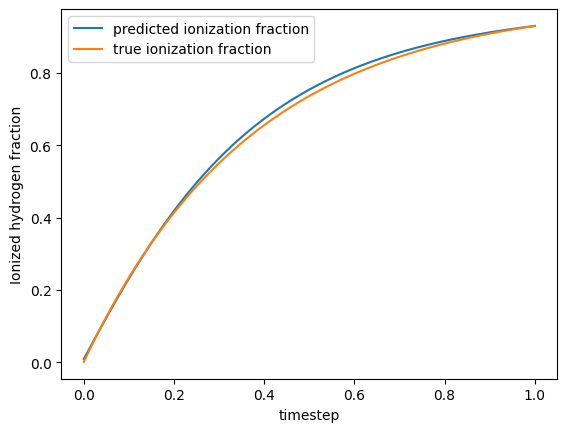

In [18]:
run_eval(x_time, y_one_params, run)

## Does it work for different parameters

In [19]:
def score(x_test, y_test):
    yh = model(x_test)
    return r2_score(yh, y_test)


nH_0, gamma_0 = params[0]

results_dif = []
results_val = []
for i in range(2000):
    nH, gamma = params[i]
    results_dif.append((np.abs(nH - nH_0), np.abs(gamma - gamma_0)))
    y = torch.tensor(data[i]).float().view(-1,1)
    results_val.append(score(x_time, y).item())

In [20]:
len(results_val), len([res for res in results_val if res > -1])

(2000, 387)

In [21]:
b = -np.logspace(np.log10(0.1),np.log10(2e8), 50)[::-1]
b = list(b) + [0, 0.5, 0.8, 1]

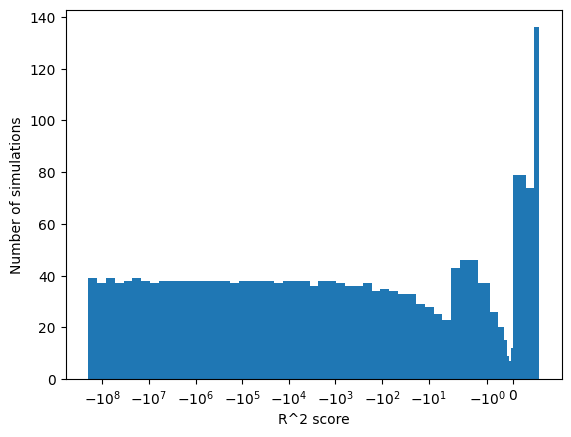

In [22]:
plt.hist(results_val, bins= b)
plt.xscale('symlog')
plt.xlabel('R^2 score')
plt.ylabel('Number of simulations')
plt.show()

In [23]:
results_dif = np.array(results_dif)
results_val = np.array(results_val)

print("max difference between nH and nH_0 to have good approximation: ", results_dif[results_val > 0.99].max(axis=0)[0])
print("max difference between Gamma and Gamma_0 to have good approximation: ", results_dif[results_val > 0.99].max(axis=0)[1])

max difference between nH and nH_0 to have good approximation:  8.131653219899944e-08
max difference between Gamma and Gamma_0 to have good approximation:  2.1991478230090445e-14


# For several parameters

In [24]:
x = torch.zeros((2000, 10000, 3)) # n_simulations * n_timesteps * feature_dim
for i, row in enumerate(params):
    row = row * np.array([N_SCALE, GAMMA_SCALE])
    row_2d = np.broadcast_to(row, (10000, 2))
    row_2d = torch.tensor(row_2d).float()
    x[i] = torch.hstack((timesteps * TIMESTEP_SCALE, row_2d))
timesteps = torch.tensor(u_time).float().view(-1,1)
y = torch.tensor(data).float()

### Basic model

In [25]:
model = FCN_with_last_activation([3, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_no_physics')

run.data_handler = DataHandlerForAllSimulations(x, y, resample_ood_runs=False)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(10)

Total num of the batches:  1800


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:40<00:00,  4.03s/it]


R2 best simulation:  0.99525166
R2 worst simulation:  -8202846.0


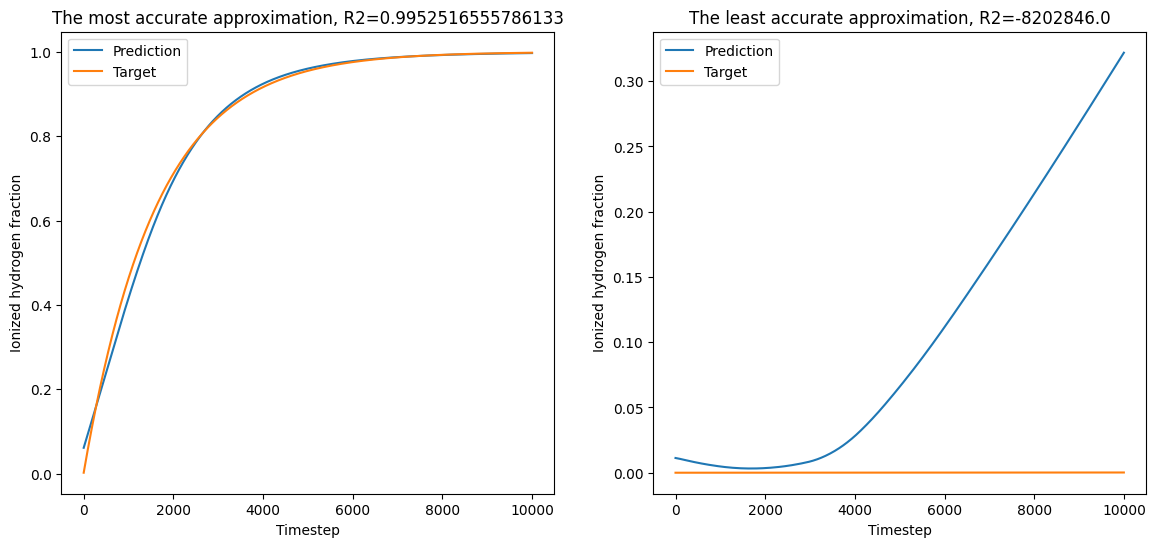

In [26]:
r2_scores_1 = all_run_eval(run)

In [27]:
len(r2_scores_1[r2_scores_1<=-1]), len(r2_scores_1[r2_scores_1>-1])

(134, 66)

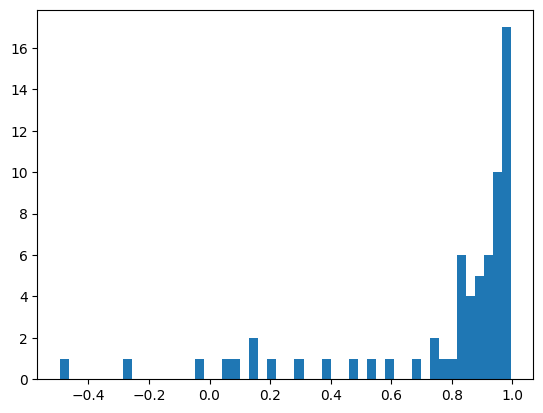

In [28]:
plt.hist(r2_scores_1[r2_scores_1>-1], bins=50)
plt.show()

In [29]:
model = FCN_with_parallel_branch([1, 8, 8, 8], [2, 8, 8, 8], [ 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_no_physics_parallel_branches')

run.data_handler = DataHandlerForAllSimulations(x, y, resample_ood_runs=False)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(10)

Total num of the batches:  1800


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:58<00:00,  5.86s/it]


R2 best simulation:  0.9959121
R2 worst simulation:  -15411534.0


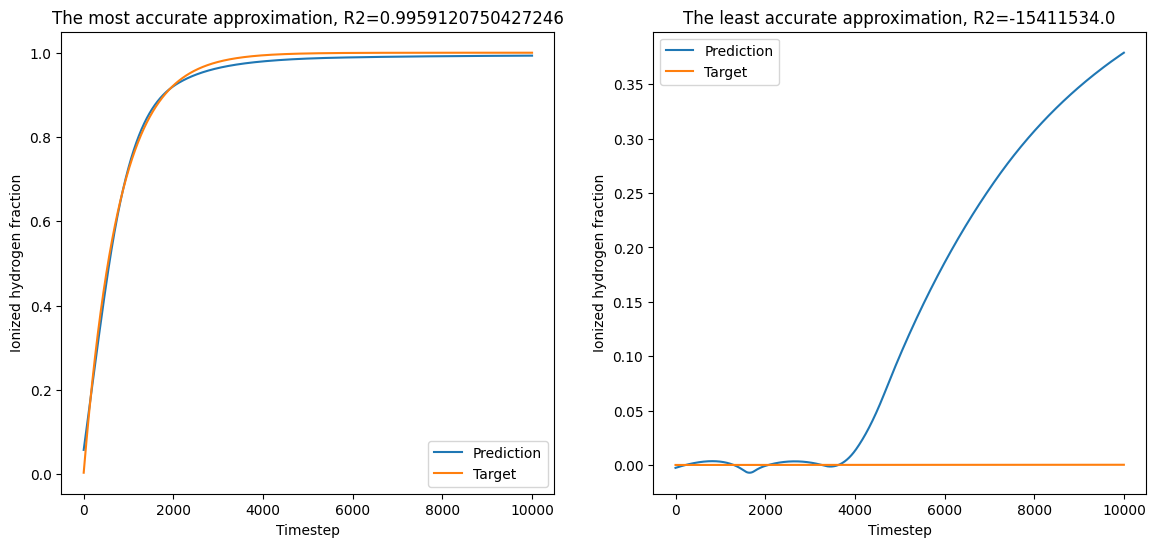

In [30]:
r2_scores_2 = all_run_eval(run)

### Model with physics loss

In [31]:
model = FCN_with_last_activation([3, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim')

run.data_handler = DataHandlerForAllSimulations(x, y, resample_ood_runs=False)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_varied_gamma_n(x, y, loss_coef=1e5)

run.train(20)

Total num of the batches:  1800


100%|██████████| 20/20 [02:34<00:00,  7.70s/it]


We test the model on 10% of all simulations, for each simulation independently we make prediction for all timesteps and calculate R2 score

R2 best simulation:  0.9839616
R2 worst simulation:  -10804666.0


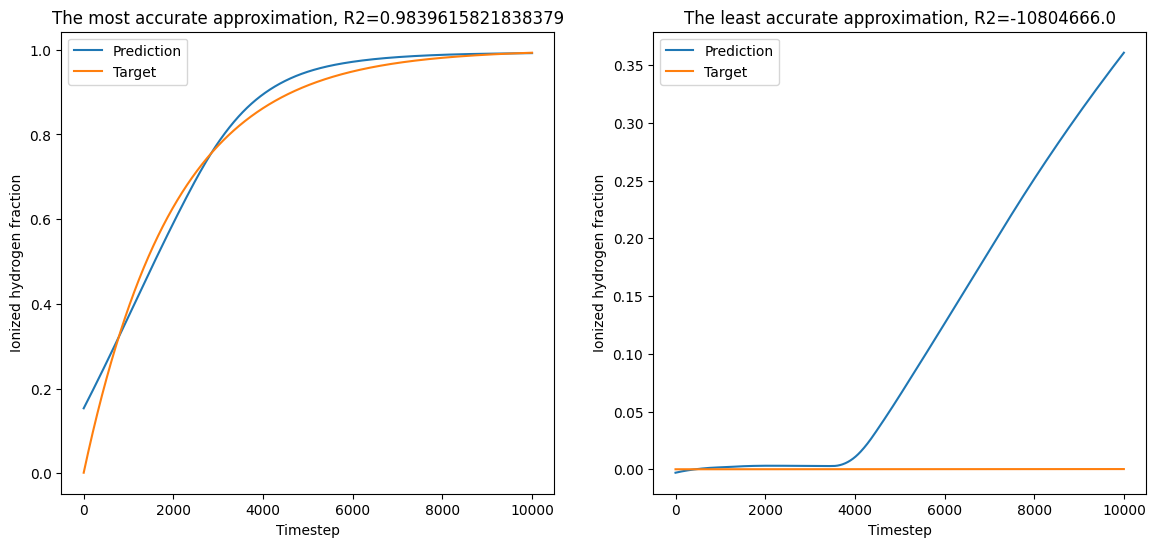

In [32]:
r2_scores_3 = all_run_eval(run)

In [33]:
model = FCN_with_parallel_branch([1, 8, 8, 8], [2, 8, 8, 8], [ 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_parallel_branches')

run.data_handler = DataHandlerForAllSimulations(x, y, resample_ood_runs=False)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_varied_gamma_n(x, y, loss_coef=1e5)

run.train(20)

Total num of the batches:  1800


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [03:07<00:00,  9.40s/it]


R2 best simulation:  0.99467593
R2 worst simulation:  -21548800.0


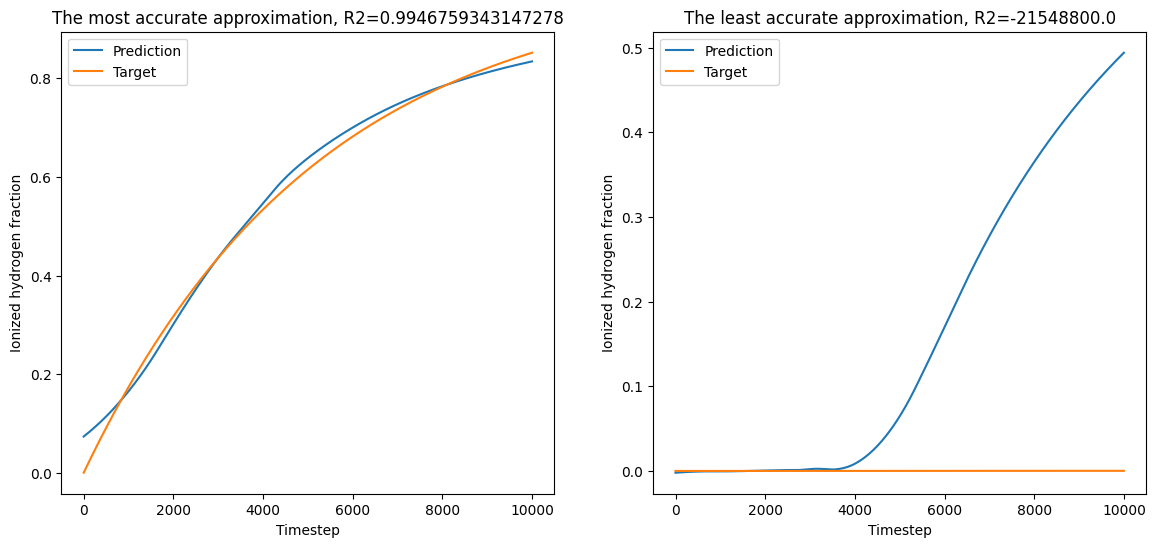

In [34]:
r2_scores_4 = all_run_eval(run)

# Weighted sampling

Total num of the batches:  1800


100%|██████████| 10/10 [00:34<00:00,  3.49s/it]


R2 best simulation:  0.9881642
R2 worst simulation:  -4287640.5


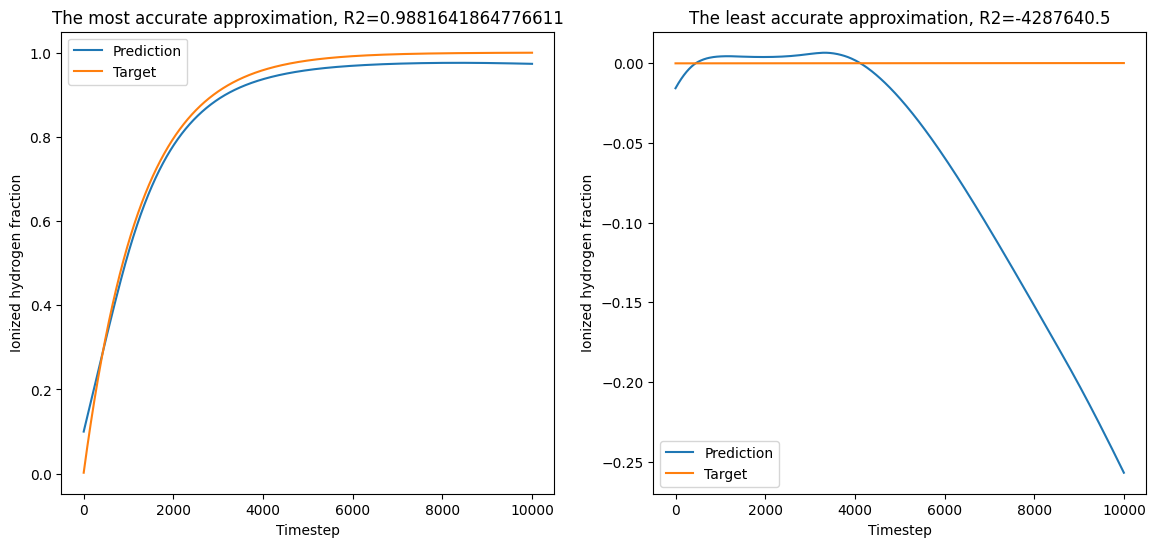

In [35]:
model = FCN_with_last_activation([3, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_no_physics_weighted')

run.data_handler = DataHandlerForAllSimulations(x, y, resample_ood_runs=True)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(10)
r2_scores_5 = all_run_eval(run)

Total num of the batches:  1800


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:12<00:00,  6.64s/it]


R2 best simulation:  0.993171
R2 worst simulation:  -126727.13


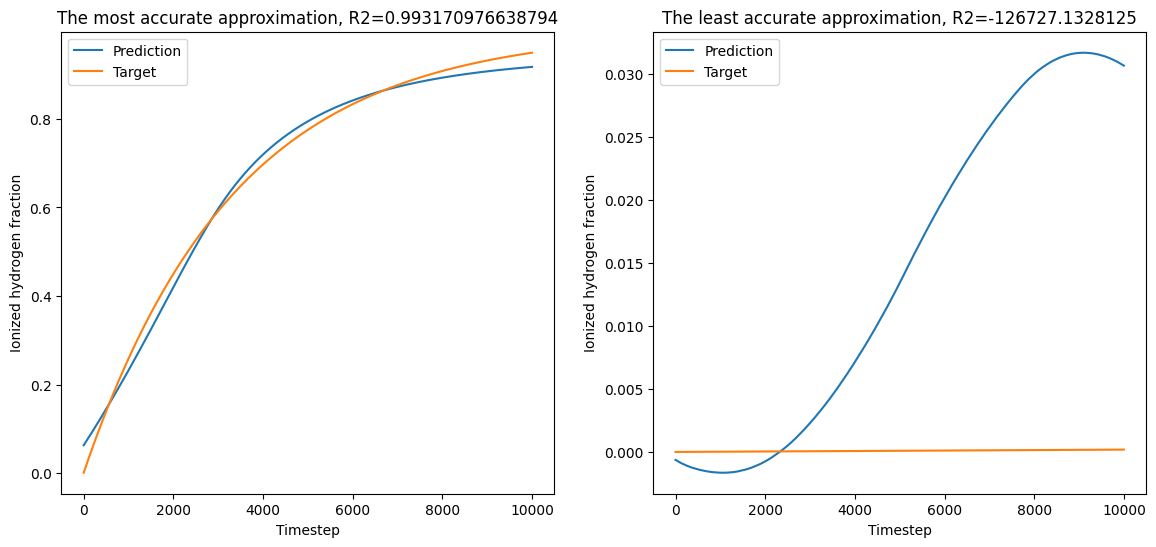

In [36]:
model = FCN_with_last_activation([3, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_weighted')

run.data_handler = DataHandlerForAllSimulations(x, y, resample_ood_runs=True)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_varied_gamma_n(x, y, loss_coef=1e5)

run.train(20)
r2_scores_6 = all_run_eval(run)

Compare R^2 score distribution

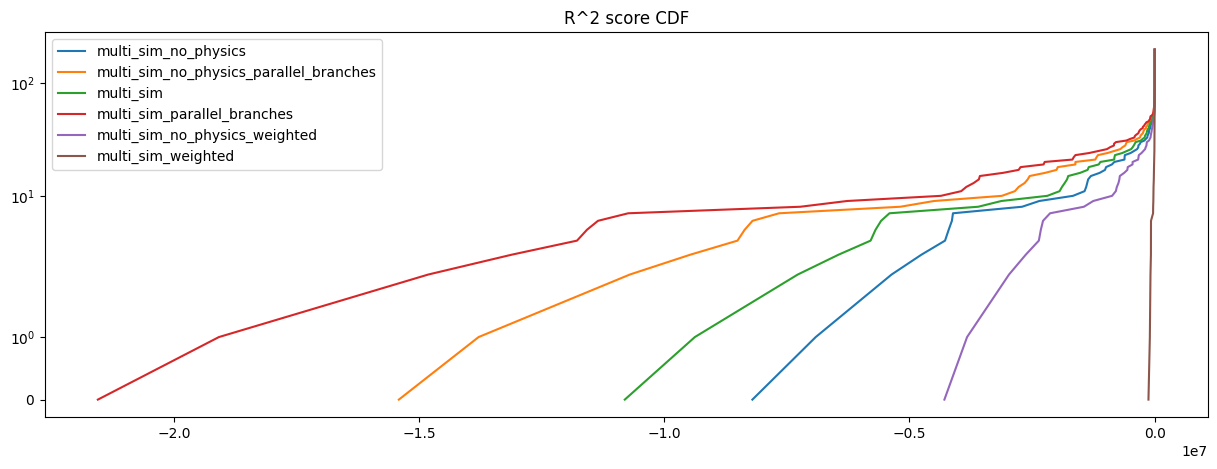

In [37]:
plt.figure(figsize=(15, 5))

plt.plot(sorted(r2_scores_1), np.arange(200), label='multi_sim_no_physics')
plt.plot(sorted(r2_scores_2), np.arange(200), label='multi_sim_no_physics_parallel_branches')
plt.plot(sorted(r2_scores_3), np.arange(200), label='multi_sim')
plt.plot(sorted(r2_scores_4), np.arange(200), label='multi_sim_parallel_branches')
plt.plot(sorted(r2_scores_5), np.arange(200), label='multi_sim_no_physics_weighted')
plt.plot(sorted(r2_scores_6), np.arange(200), label='multi_sim_weighted')
plt.legend()
plt.yscale('symlog')

plt.title("R^2 score CDF")
plt.show()

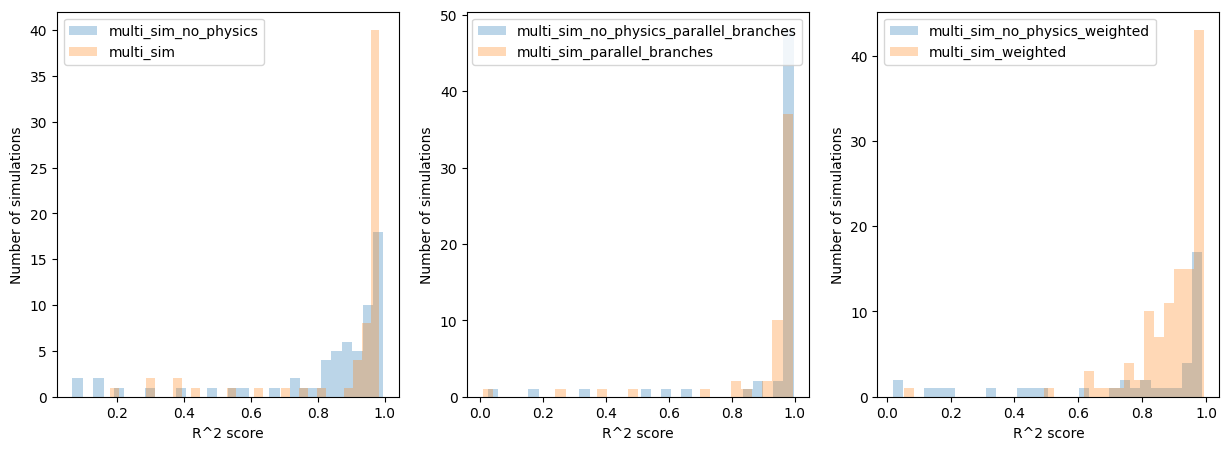

In [38]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(r2_scores_1[r2_scores_1 > 0], bins=30, alpha=0.3, label='multi_sim_no_physics')
plt.hist(r2_scores_3[r2_scores_3 > 0], bins=30, alpha=0.3, label='multi_sim')

plt.xlabel('R^2 score')
plt.ylabel('Number of simulations')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(r2_scores_2[r2_scores_2 > 0], bins=30, alpha=0.3, label='multi_sim_no_physics_parallel_branches')
plt.hist(r2_scores_4[r2_scores_4 > 0], bins=30, alpha=0.3, label='multi_sim_parallel_branches')

plt.xlabel('R^2 score')
plt.ylabel('Number of simulations')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(r2_scores_5[r2_scores_5 > 0], bins=30, alpha=0.3, label='multi_sim_no_physics_weighted')
plt.hist(r2_scores_6[r2_scores_6 > 0], bins=30, alpha=0.3, label='multi_sim_weighted')

plt.xlabel('R^2 score')
plt.ylabel('Number of simulations')
plt.legend()


plt.show()

# Training two separate models

Total num of the batches:  1800


100%|██████████| 10/10 [01:11<00:00,  7.18s/it]


R2 best simulation:  0.9957653
R2 worst simulation:  -4.154426


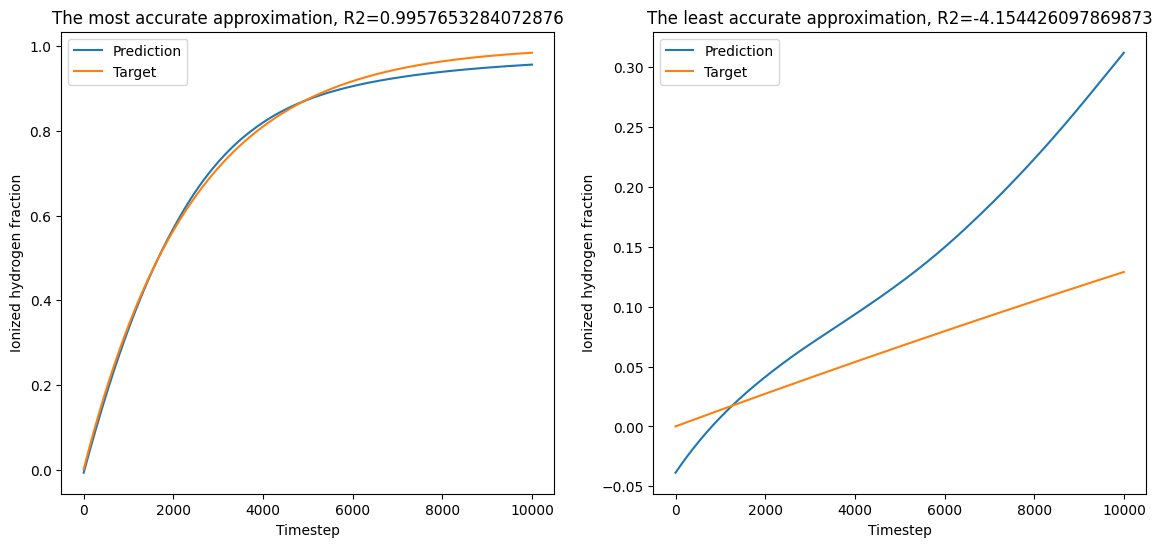

In [39]:
model_usual = FCN_with_last_activation([3, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model_usual.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_no_physics_for_usual_samples')

run.data_handler = DataHandlerForAllSimulations(x, y, resample_ood_runs=True, ood_weight=0., normal_weight=1.)
run.model = model_usual
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(10)
r2_scores_7 = all_run_eval(run)

Total num of the batches:  1800


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:00<00:00,  6.00s/it]


R2 best simulation:  0.99727595
R2 worst simulation:  -24860.396


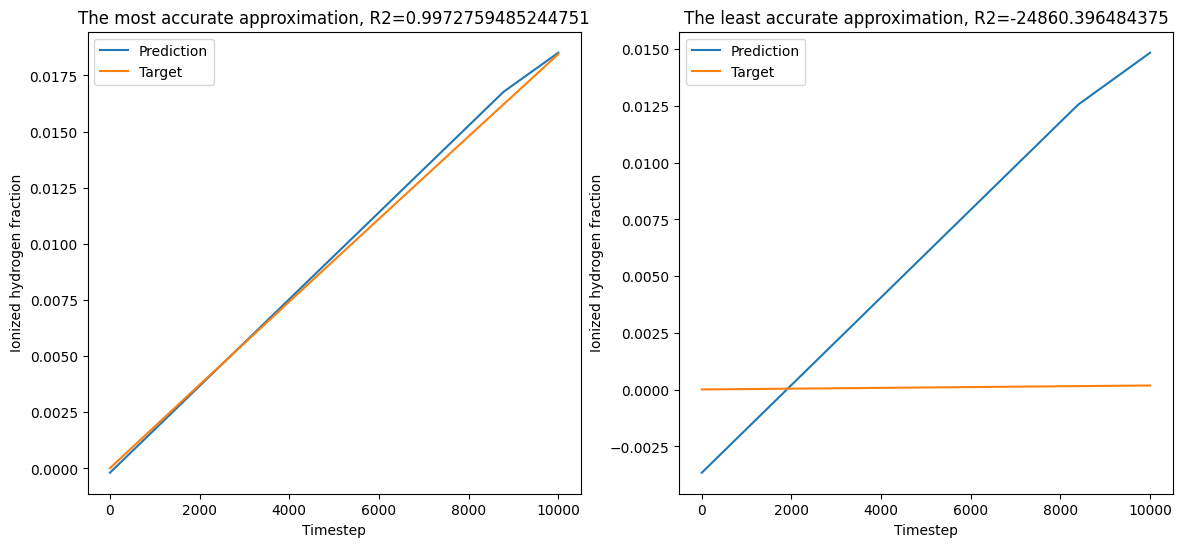

In [40]:
model_ood = FCN([3, 8, 8, 8, 8, 1])
optimizer = torch.optim.Adam(model_ood.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_no_physics_for_ood_samples')

run.data_handler = DataHandlerForAllSimulations(x, y, resample_ood_runs=True, ood_weight=1., normal_weight=0.)
run.model = model_ood
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(10)
r2_scores_8 = all_run_eval(run)

### PINN

Total num of the batches:  1800


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [03:07<00:00,  9.36s/it]


R2 best simulation:  0.98399264
R2 worst simulation:  -9.585002


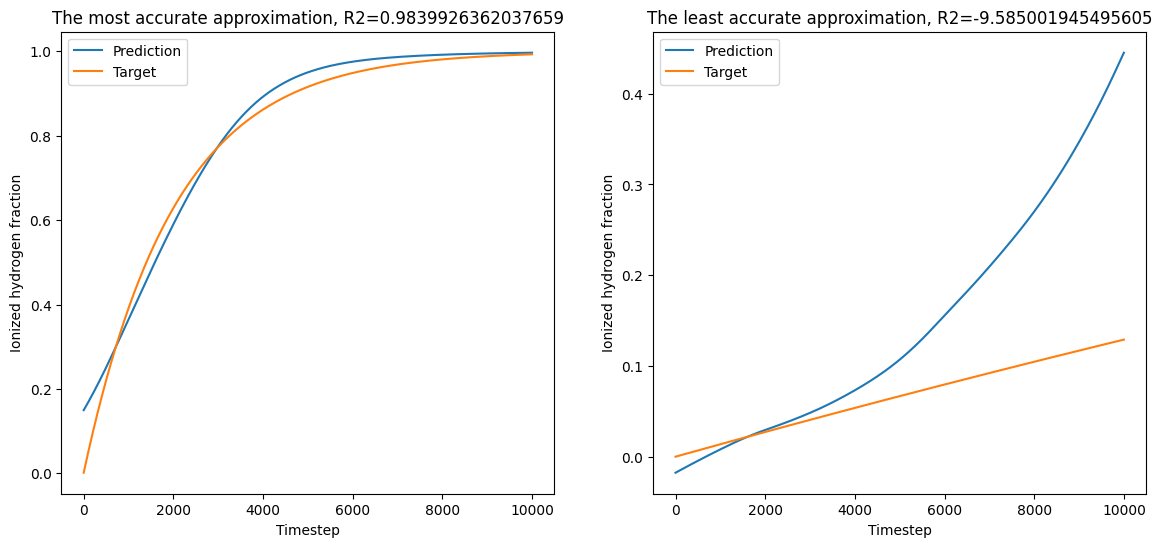

In [41]:
model_usual = FCN_with_last_activation([3, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model_usual.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_for_usual_samples')

run.data_handler = DataHandlerForAllSimulations(x, y, resample_ood_runs=True, ood_weight=0., normal_weight=1.)
run.model = model_usual
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_varied_gamma_n(x, y, loss_coef=1e5)

run.train(20)
r2_scores_9 = all_run_eval(run)

Total num of the batches:  1800


100%|██████████| 20/20 [02:05<00:00,  6.27s/it]


R2 best simulation:  0.23895252
R2 worst simulation:  -5103.3027


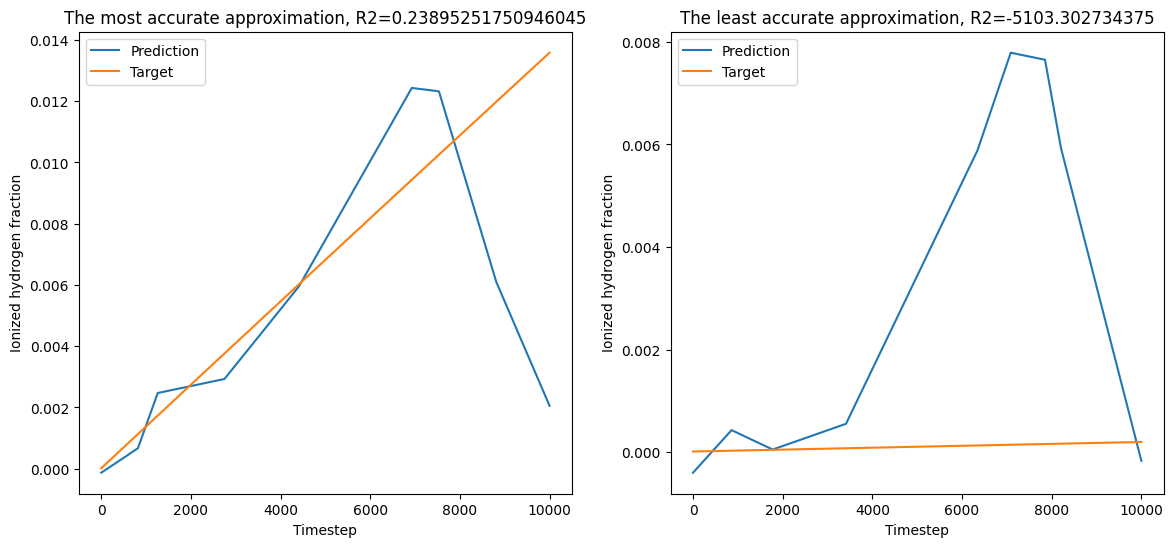

In [42]:
model_ood = FCN([3, 8, 8, 8, 8, 1])
optimizer = torch.optim.Adam(model_ood.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('multi_sim_for_ood_samples')

run.data_handler = DataHandlerForAllSimulations(x, y, resample_ood_runs=True, ood_weight=1., normal_weight=0.)
run.model = model_ood
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_varied_gamma_n(x, y, loss_coef=1e5)

run.train(20)
r2_scores_10 = all_run_eval(run)